# Building Models for eCommerce Fraud Detection

## Table of Contents
*  
    * [Part 1 : Data Loading, Transformation and Exploration](#part-1)
    * [Part 2 : Feature extraction and ML training](#part-2)
    * [Part 3 : Customer Segmentation and Knowledge sharing with K-Mean](#part-3)
    * [Part 4 : Data Ethics, Privacy, and Security](#part-4)

# Part 1: Data Loading, Transformation and Exploration <a class="anchor" name="part-1"></a>
## 1.1 Data Loading
In this section, you must load the given datasets into PySpark DataFrames and use DataFrame functions to process the data. Spark SQL usage is discouraged, and you can only use pandas to format results. For plotting, various visualisation packages can be used, but please ensure that you have included instructions to install the additional packages and that the installation will be successful in the provided docker container (in case your marker needs to clear the notebook and rerun it).

### 1.1.1 Data Loading <a class="anchor" name="1.1"></a>
1.1.1 Write the code to create a SparkSession. For creating the SparkSession, you need to use a SparkConf object to configure the Spark app with a proper application name, to ensure the maximum partition size does not exceed 16MB, and to run locally with all CPU cores on your machine (note: if you have insufficient RAM, reducing the number of cores is acceptable.)  (2%)

In [1]:
from pyspark import SparkConf
from pyspark.sql import SparkSession

# Create SparkConf object based on the requirements
spark_conf = (SparkConf()
              .setAppName("eCommerce Fraud Detection")
              .set("spark.sql.files.maxPartitionBytes", "16MB")
              .set("spark.executor.memory", "2g")  
              .set("spark.driver.memory", "2g")    
              .set("spark.executor.cores", "2")    
              .set("spark.sql.shuffle.partitions", "100")
              .setMaster("local[*]"))

# Initialize SparkSession using the SparkConf object
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()

# Reduce log verbosity by setting log level to 'ERROR'
spark.sparkContext.setLogLevel("ERROR")

print(f"Spark version: {spark.version}")
print(f"Application name: {spark.sparkContext.appName}")


Spark version: 3.5.0
Application name: eCommerce Fraud Detection


1.1.2 Write code to define the schemas for the category, customer, product, browsing behaviour and transaction datasets, following the data types suggested in the metadata file. (3%)

In [2]:
from pyspark.sql.types import (StructType, StructField, StringType, IntegerType, 
                               DateType, FloatType, TimestampType, BooleanType)

# Define schema for customer.csv
customer_schema = StructType([
    StructField("customer_id", StringType(), True),
    StructField("first_name", StringType(), True),
    StructField("last_name", StringType(), True),
    StructField("username", StringType(), True),
    StructField("email", StringType(), True),
    StructField("gender", StringType(), True),
    StructField("birthdate", DateType(), True),  
    StructField("first_join_date", DateType(), True) 
])

# Define schema for category.csv
category_schema = StructType([
    StructField("category_id", StringType(), True),
    StructField("cat_level1", StringType(), True),
    StructField("cat_level2", StringType(), True),
    StructField("cat_level3", StringType(), True)
])

# Define schema for browsing_behaviour.csv
browsing_behaviour_schema = StructType([
    StructField("session_id", StringType(), True),
    StructField("event_type", StringType(), True),
    StructField("event_time", TimestampType(), True),  
    StructField("traffic_source", StringType(), True),
    StructField("device_type", StringType(), True)
])

# Define schema for product.csv
product_schema = StructType([
    StructField("id", StringType(), True),
    StructField("gender", StringType(), True),
    StructField("baseColour", StringType(), True),
    StructField("season", StringType(), True),
    StructField("year", IntegerType(), True),
    StructField("usage", StringType(), True),
    StructField("productDisplayName", StringType(), True),
    StructField("category_id", StringType(), True)
])

# Define schema for transaction.csv
transaction_schema = StructType([
    StructField("created_at", TimestampType(), True),  
    StructField("customer_id", StringType(), True),
    StructField("transaction_id", StringType(), True),
    StructField("session_id", StringType(), True),
    StructField("product_metadata", StringType(), True),
    StructField("payment_method", StringType(), True),
    StructField("payment_status", StringType(), True),
    StructField("promo_amount", FloatType(), True),
    StructField("promo_code", StringType(), True),
    StructField("shipment_fee", FloatType(), True),
    StructField("shipment_location_lat", FloatType(), True),
    StructField("shipment_location_long", FloatType(), True),
    StructField("total_amount", FloatType(), True),
    StructField("clear_payment", StringType(), True)
])

# Define schema for customer_session.csv
customer_session_schema = StructType([
    StructField("session_id", StringType(), True),
    StructField("customer_id", StringType(), True)
])

# Define schema for fraud_transaction.csv
fraud_transaction_schema = StructType([
    StructField("transaction_id", StringType(), True),
    StructField("is_fraud", BooleanType(), True)  
])

1.1.3 Using predefined schemas, write code to load the CSV files into separate data frames. Print the schemas of all data frames. (2%)

In [3]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("eCommerce_Fraud_Detection").getOrCreate()

# Assigning files to a variable 
customer_csv_path = "customer.csv"
category_csv_path = "category.csv"
browsing_behaviour_csv_path = "browsing_behaviour.csv"
product_csv_path = "product.csv"
transaction_csv_path = "transactions.csv"
customer_session_csv_path = "customer_session.csv"
fraud_transaction_csv_path = "fraud_transaction.csv"

# Implementing predefined schemas on the loaded files and converting them into data frames 
df_customer = spark.read.format("csv").schema(customer_schema).option("header", "true").load(customer_csv_path)
df_category = spark.read.format("csv").schema(category_schema).option("header", "true").load(category_csv_path)
df_browsing_behaviour = spark.read.format("csv").schema(browsing_behaviour_schema).option("header", "true").load(browsing_behaviour_csv_path)
df_product = spark.read.format("csv").schema(product_schema).option("header", "true").load(product_csv_path)
df_transaction = spark.read.format("csv").schema(transaction_schema).option("header", "true").load(transaction_csv_path)
df_customer_session = spark.read.format("csv").schema(customer_session_schema).option("header", "true").load(customer_session_csv_path)
df_fraud_transaction = spark.read.format("csv").schema(fraud_transaction_schema).option("header", "true").load(fraud_transaction_csv_path)

# Schema for each DataFrame
print("Customer DataFrame Schema:")
df_customer.printSchema()

print("\nCategory DataFrame Schema:")
df_category.printSchema()

print("\nBrowsing Behaviour DataFrame Schema:")
df_browsing_behaviour.printSchema()

print("\nProduct DataFrame Schema:")
df_product.printSchema()

print("\nTransaction DataFrame Schema:")
df_transaction.printSchema()

print("\nCustomer Session DataFrame Schema:")
df_customer_session.printSchema()

print("\nFraud Transaction DataFrame Schema:")
df_fraud_transaction.printSchema()


Customer DataFrame Schema:
root
 |-- customer_id: string (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- username: string (nullable = true)
 |-- email: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- birthdate: date (nullable = true)
 |-- first_join_date: date (nullable = true)


Category DataFrame Schema:
root
 |-- category_id: string (nullable = true)
 |-- cat_level1: string (nullable = true)
 |-- cat_level2: string (nullable = true)
 |-- cat_level3: string (nullable = true)


Browsing Behaviour DataFrame Schema:
root
 |-- session_id: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- event_time: timestamp (nullable = true)
 |-- traffic_source: string (nullable = true)
 |-- device_type: string (nullable = true)


Product DataFrame Schema:
root
 |-- id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- baseColour: string (nullable = true)
 |-- season: string (nullable =

### 1.2 Data Transformation to Create Features <a class="anchor" name="1.2"></a>
In the browsing behaviour dataset, there are 10 types of events:  
VC(Viewing Category), VI(Viewing Item), VP(Viewing Promotion), AP(Add Promotion), CL(Click on a product/category) , ATC(Add a product to Shopping Cart), CO(CheckOut), HP(View HomePage), SCR(Mouse Scrolling), SER(Search for a product/category)  
We categorise them into three different levels:  
L1(actions that are highly likely lead to a purchase): AP, ATC, CO  
L2(actions may lead to purchase): VC, VP, VI, SER  
L3(not very important - just browsing):  SCR, HP, CL  
Perform the following tasks based on the loaded data frames and create a new data frame.  

1.2.1 For each transaction (linked to a browsing session), count the number of actions in each level and create 3 columns(L1_count, L2_count, L3_count).

In [4]:
from pyspark.sql import functions as P


# Categorizing event types into L1, L2, L3 levels
event_level_mapping = P.when(P.col("event_type").isin("AP", "ATC", "CO"), "L1") \
                       .when(P.col("event_type").isin("VC", "VP", "VI", "SER"), "L2") \
                       .when(P.col("event_type").isin("SCR", "HP", "CL"), "L3")

df_browsing_behaviour = df_browsing_behaviour.withColumn("event_level", event_level_mapping)

# Counting the number of actions for each level
df_event_counts = df_browsing_behaviour.groupBy("session_id").pivot("event_level", ["L1", "L2", "L3"]).count()

# Sessions with null values will be filled with 0
df_event_counts = df_event_counts.fillna(0)

# Renaming Columns 
df_event_counts = df_event_counts.withColumnRenamed("L1", "L1_count") \
                                 .withColumnRenamed("L2", "L2_count") \
                                 .withColumnRenamed("L3", "L3_count")

# performing left join between event counts and transaction data using session_id
main_feature_df = df_transaction.join(df_event_counts, on="session_id", how="left")

# Data Frame with newly added column
main_feature_df.select("transaction_id", "session_id", "L1_count", "L2_count", "L3_count").show(10)



+--------------------+--------------------+--------+--------+--------+
|      transaction_id|          session_id|L1_count|L2_count|L3_count|
+--------------------+--------------------+--------+--------+--------+
|aa5cc090-31d7-468...|39c4223a-2cfb-4ec...|       8|       0|       2|
|8503549d-26b6-4ec...|42b6381a-beaa-419...|       7|       4|       9|
|f31c5b2f-c694-4ea...|42be3c72-182d-4dc...|       2|       7|      15|
|9df333af-a769-48f...|42d0d211-7def-413...|       3|       3|       2|
|5a569594-2d46-47b...|42d17614-4f00-400...|       3|       1|       3|
|e9d96f47-19a4-482...|43450c38-1d42-47c...|       2|       0|       4|
|e94b11d8-135f-460...|43624b16-ee04-44e...|       8|      12|      31|
|f4402a70-b26b-425...|43b1fb4d-0901-4b5...|       2|      10|      20|
|ddd24373-f13e-473...|4cd8497a-4a18-421...|       3|       1|       1|
|f6c688e8-ae0b-4a3...|4d12d8af-39f8-4ae...|       6|       4|       6|
+--------------------+--------------------+--------+--------+--------+
only s

1.2.2 Create two columns with a percentage ratio of L1 and L2 actions. (i.e. L1 ratio = L1/(L1+L2+L3) * 100%)

In [5]:
# Creating percentage ratio of L1 and L2 actions 
main_feature_df = main_feature_df.withColumn(
    "L1_ratio", 
    P.round((P.col("L1_count") / (P.col("L1_count") + P.col("L2_count") + P.col("L3_count"))) * 100, 4)
).withColumn(
    "L2_ratio", 
    P.round((P.col("L2_count") / (P.col("L1_count") + P.col("L2_count") + P.col("L3_count"))) * 100, 4)
)

# Resulting data frame 
main_feature_df.select("session_id","L1_count", "L2_count", "L3_count", "L1_ratio", "L2_ratio").show(10, truncate=False)

+------------------------------------+--------+--------+--------+--------+--------+
|session_id                          |L1_count|L2_count|L3_count|L1_ratio|L2_ratio|
+------------------------------------+--------+--------+--------+--------+--------+
|39c4223a-2cfb-4ec5-9914-199869bd10cd|8       |0       |2       |80.0    |0.0     |
|42b6381a-beaa-4190-af79-fd60182739c5|7       |4       |9       |35.0    |20.0    |
|42be3c72-182d-4dcc-b64d-a2326c65532b|2       |7       |15      |8.3333  |29.1667 |
|42d0d211-7def-4132-8335-8ecf7588d04d|3       |3       |2       |37.5    |37.5    |
|42d17614-4f00-4002-b060-d12c33800b84|3       |1       |3       |42.8571 |14.2857 |
|43450c38-1d42-47c2-b4b8-d91488e16623|2       |0       |4       |33.3333 |0.0     |
|43624b16-ee04-44ee-b297-95bbb985dcdf|8       |12      |31      |15.6863 |23.5294 |
|43b1fb4d-0901-4b5f-addc-c060a577ba2f|2       |10      |20      |6.25    |31.25   |
|4cd8497a-4a18-421e-89f9-f54f04613249|3       |1       |1       |60.0    |20

1.2.3 For each unique browsing session, based on event_time, extract the time of day as 4 groups: morning(6am-11:59am), afternoon(12pm-5:59pm), evening(6pm-11:59pm), night(12am-5:59am), add a column. (note: use medium time if a browsing session spans across different groups. For example, if a session starts at 10 am and ends at 1 pm, use 11:30 => (10+13)/2).

In [7]:
from pyspark.sql import functions as F
from pyspark.sql.types import StringType

# Decoding start time and end time of browsing 
session_times = df_browsing_behaviour.groupBy("session_id").agg(
    F.min("event_time").alias("start_time"),
    F.max("event_time").alias("end_time")
)

# Start and end times to UNIX timestamps
session_times = session_times.withColumn("start_time_unix", F.unix_timestamp("start_time"))
session_times = session_times.withColumn("end_time_unix", F.unix_timestamp("end_time"))

# Calculating the medium time
session_times = session_times.withColumn("medium_time_unix", 
                                         ((F.col("start_time_unix") + F.col("end_time_unix")) / 2))

session_times = session_times.withColumn("medium_time", F.from_unixtime("medium_time_unix"))

# Extracting the hour of the day from the medium time
session_times = session_times.withColumn("hour_of_day", F.hour("medium_time"))

# Implementing UDF to cetgorize the time groups 
def categorize_time_of_day(hour):
    if 6 <= hour < 12:
        return "morning"
    elif 12 <= hour < 18:
        return "afternoon"
    elif 18 <= hour < 24:
        return "evening"
    else:
        return "night"

# Registering the UDF
categorize_time_udf = F.udf(categorize_time_of_day, StringType())

# Application of the UDF for a new column 
session_times = session_times.withColumn("time_of_day", categorize_time_udf(F.col("hour_of_day")))

# Joining the session_times DataFrame with main_feature_df on session_id to add hour_of_day and time_of_day
main_feature_df = main_feature_df.join(
    session_times.select("session_id", "hour_of_day", "time_of_day"), 
    on="session_id", 
    how="left"
)

main_feature_df.select("session_id", "hour_of_day", "time_of_day").show(10, truncate=False)


+------------------------------------+-----------+-----------+
|session_id                          |hour_of_day|time_of_day|
+------------------------------------+-----------+-----------+
|39c4223a-2cfb-4ec5-9914-199869bd10cd|21         |evening    |
|42b6381a-beaa-4190-af79-fd60182739c5|8          |morning    |
|42be3c72-182d-4dcc-b64d-a2326c65532b|15         |afternoon  |
|42d0d211-7def-4132-8335-8ecf7588d04d|11         |morning    |
|42d17614-4f00-4002-b060-d12c33800b84|4          |night      |
|43450c38-1d42-47c2-b4b8-d91488e16623|7          |morning    |
|43624b16-ee04-44ee-b297-95bbb985dcdf|20         |evening    |
|43b1fb4d-0901-4b5f-addc-c060a577ba2f|15         |afternoon  |
|4cd8497a-4a18-421e-89f9-f54f04613249|10         |morning    |
|4d12d8af-39f8-4ae8-80a0-c7b0cbe75661|16         |afternoon  |
+------------------------------------+-----------+-----------+
only showing top 10 rows



1.2.4 Join data frames to find customer information and add columns to feature_df: gender, age, geolocation, first join year. (note: For some columns, you need to perform transformations. For age, keep the integer only by rounding.)

In [8]:
from pyspark.sql import functions as F

# Extracting additional required columns from the customer dataframe
df_customer_transformed = df_customer.withColumn("first_join_year", F.year(F.col("first_join_date")))

# Calculating the age based on the birthdate
current_year = F.year(F.current_date())
df_customer_transformed = df_customer_transformed.withColumn("age", 
    F.floor(current_year - F.year(F.col("birthdate"))))

# Join the customer information to the feature dataframe (main_feature_df) on customer_id
main_feature_df = main_feature_df.join(df_customer_transformed.select(
    "customer_id", "gender", "age", "first_join_year"), on="customer_id", how="left")

# Extracting geolocation from the transaction data into single column
main_feature_df = main_feature_df.withColumn(
    "geolocation", 
    F.concat(F.col("shipment_location_lat"), F.lit(", "), F.col("shipment_location_long"))
)

main_feature_df.select("customer_id", "gender", "age", "geolocation", "first_join_year").show(10, truncate=False)


+-----------+------+---+-----------------------+---------------+
|customer_id|gender|age|geolocation            |first_join_year|
+-----------+------+---+-----------------------+---------------+
|14159      |F     |31 |-4.2635126, 105.4894   |2019           |
|22576      |F     |32 |-7.9170766, 110.131874 |2020           |
|18696      |F     |28 |-7.396614, 109.51126   |2020           |
|90136      |F     |24 |-0.63729054, 109.49252 |2017           |
|18960      |F     |24 |-7.320041, 111.2258    |2018           |
|60646      |F     |26 |-4.523286, 105.3858    |2018           |
|5901       |F     |26 |-7.432102, 111.09696   |2018           |
|69072      |F     |22 |-6.2635517, 106.85972  |2017           |
|92076      |F     |46 |-0.42055696, 113.931755|2017           |
|51799      |F     |35 |-2.9836543, 101.931046 |2018           |
+-----------+------+---+-----------------------+---------------+
only showing top 10 rows



1.2.5 Join data frames to find out the number of purchases the customer has made, add a column.

In [9]:
from pyspark.sql import functions as F

# Grouping by customer_id and count the number of transactions for each customer for sucessful purchase
purchases_df = main_feature_df.filter(F.col("clear_payment") == "1") \
    .groupBy("customer_id") \
    .agg(F.count("transaction_id").alias("purchase_count"))

# Joining purchase count to feature df on customer_id
main_feature_df = main_feature_df.join(purchases_df, on="customer_id", how="left")

main_feature_df = main_feature_df.fillna({"purchase_count": 0})

# Updated dataframe
main_feature_df.select("customer_id", "purchase_count").show(10, truncate=False)

+-----------+--------------+
|customer_id|purchase_count|
+-----------+--------------+
|32840      |48            |
|5901       |18            |
|92076      |50            |
|14159      |76            |
|18960      |19            |
|69072      |226           |
|51799      |48            |
|90136      |20            |
|60646      |50            |
|18696      |36            |
+-----------+--------------+
only showing top 10 rows



1.2.6 Attach the transaction labels for fraud/non-fraud.

In [10]:
from pyspark.sql import functions as F

# Use a left join to apply the fraud label to the transactions in main_feature_df.
main_feature_df = main_feature_df.join(df_fraud_transaction.select("transaction_id", "is_fraud"), 
                                       on="transaction_id", how="left")

# Set non-fraud transactions to zero (because df_fraud_transaction only includes fraudulent transactions).
main_feature_df = main_feature_df.fillna({"is_fraud": 0})

# Updating the dataframe
main_feature_df.select("transaction_id", "is_fraud").show(20, truncate=False)

+------------------------------------+--------+
|transaction_id                      |is_fraud|
+------------------------------------+--------+
|511f59f8-3ef5-4388-b654-1a8c3da62819|false   |
|8e509f58-7f8d-421d-b7bf-8f41db0ed911|false   |
|29d32f23-a07a-4f20-a3c4-77801ad2516c|false   |
|a3e90650-4db3-408d-be16-79b432af0f86|false   |
|12ffdc68-a0ba-44e6-92e5-51173a6c91b1|false   |
|430dc90b-6c04-408c-9b4e-09147c9c2367|false   |
|89a39293-dee2-48a4-b1b5-f9eda8ca688d|false   |
|cddea303-22d6-41f7-ae79-149bb915d017|false   |
|9cf8b365-0b86-4c33-ab27-c7f94746d30c|false   |
|6323379e-5dee-4d09-98d8-b2d7bccf6d09|false   |
|4a761b1e-4109-4c30-9872-9b50b4cef6bd|false   |
|d5c5d485-9d93-4d25-8891-9be210aa0d35|false   |
|b5a01723-75a9-44ef-90f3-3765cf09a4fa|false   |
|4964632a-bf22-44df-92d5-1d2ae2fec2ff|false   |
|96c23186-c8d5-4f4a-8534-0c63a091ef50|false   |
|ea8525c5-5f3e-49d4-8036-c23b0b214310|false   |
|542d5d81-3d4b-4c6b-8366-f742194ab50c|false   |
|ce994f27-b4d8-4228-8164-e9bbaedbd34a|fa

In [11]:
# Verifying columns present in the feature_df
for col_name, col_type in main_feature_df.dtypes:
    print(f"Column: {col_name}, Type: {col_type}")

Column: transaction_id, Type: string
Column: customer_id, Type: string
Column: session_id, Type: string
Column: created_at, Type: timestamp
Column: product_metadata, Type: string
Column: payment_method, Type: string
Column: payment_status, Type: string
Column: promo_amount, Type: float
Column: promo_code, Type: string
Column: shipment_fee, Type: float
Column: shipment_location_lat, Type: float
Column: shipment_location_long, Type: float
Column: total_amount, Type: float
Column: clear_payment, Type: string
Column: L1_count, Type: bigint
Column: L2_count, Type: bigint
Column: L3_count, Type: bigint
Column: L1_ratio, Type: double
Column: L2_ratio, Type: double
Column: hour_of_day, Type: int
Column: time_of_day, Type: string
Column: gender, Type: string
Column: age, Type: bigint
Column: first_join_year, Type: int
Column: geolocation, Type: string
Column: purchase_count, Type: bigint
Column: is_fraud, Type: boolean


### 1.3 Exploring the Data <a class="anchor" name="1.3"></a>
**1.3.1 With the feature_df, write code to show the basic statistics: a) For each numeric column, show count, mean, stddev, min, max, 25 percentile, 50 percentile, 75 percentile; b) For each non-numeric column, display the top-5 values and the corresponding counts; c) For each boolean column, display the value and count. (3%)**

In [12]:
import pyspark.sql.functions as F

# Statistics for numeric columns
numeric_cols = [col_name for col_name, dtype in main_feature_df.dtypes if dtype in ['int', 'float', 'bigint']]

numeric_stats = main_feature_df.select(numeric_cols).describe()

print("Numeric Columns Statistics:")
numeric_stats.show()

# To calculate 25th, 50th, and 75th percentiles
percentiles = [0.25, 0.5, 0.75]

# list to store the percentile stats
percentile_data = []

for col in numeric_cols:
    percentile_values = main_feature_df.approxQuantile(col, percentiles, 0.01)
    percentile_data.append([col, percentile_values[0], percentile_values[1], percentile_values[2]])

# converting to data frame for readable ouptut
percentile_df = spark.createDataFrame(percentile_data, ["Column", "25th Percentile", "50th Percentile", "75th Percentile"])

# Percentile stats
print("Percentiles for Numeric Columns:")
percentile_df.show(truncate=False)


# Display the top five values and counts for each non-numeric column in DataFrame format.
non_numeric_cols = [col_name for col_name, dtype in main_feature_df.dtypes if dtype == 'string']

for col in non_numeric_cols:
    print(f"Top 5 values for column '{col}':")
    top_5_values_df = main_feature_df.groupBy(col).count().orderBy("count", ascending=False).limit(5)
    top_5_values_df.show(truncate=False)


# Display each boolean column's value and count in DataFrame format.
boolean_cols = [col_name for col_name, dtype in main_feature_df.dtypes if dtype == 'boolean']

for col in boolean_cols:
    print(f"Value counts for column '{col}':")
    boolean_counts_df = main_feature_df.groupBy(col).count()
    boolean_counts_df.show(truncate=False)


Numeric Columns Statistics:
+-------+------------------+-----------------+---------------------+----------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|      promo_amount|     shipment_fee|shipment_location_lat|shipment_location_long|     total_amount|          L1_count|          L2_count|          L3_count|       hour_of_day|               age|   first_join_year|    purchase_count|
+-------+------------------+-----------------+---------------------+----------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|            657989|           657989|               657989|                657989|           657989|            657987|            657987|            657987|            657987|            657989|            657989|            657989|


**1.3.2 Explore the dataframe and write code to present two plots worthy of presentation to the company, describe your plots and discuss the findings from the plots. (8%)**
One of the plots needs to be based on feature_df in regard to fraudulent behaviour; you’re free to choose the other one.  
Hint 1: You can use basic plots (e.g., histograms, line charts, scatter plots) to show the relationship between a column and the label or more advanced plots like correlation plots.  
Hint 2: If your data is too large for plotting, consider using sampling before plotting.  
150 words max for each plot’s description and discussion  
Feel free to use any plotting libraries: matplotlib, seabon, plotly, etc.  



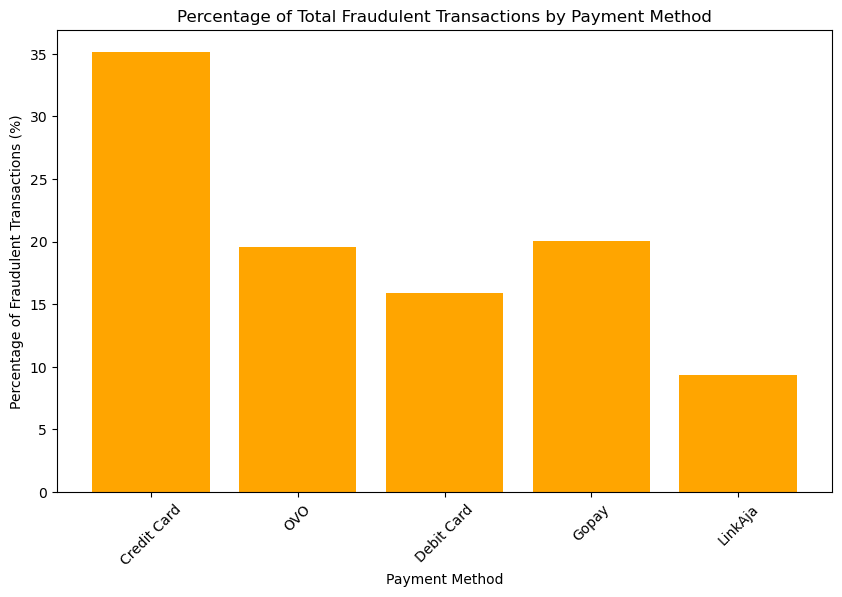

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import functions as F

# Filtering feature_df for fraudulent transactions only
fraud_df = main_feature_df.filter(main_feature_df.is_fraud == True)

# Grouping by payment method to count occurrences of fraud
payment_fraud_counts = fraud_df.groupBy("payment_method").count()

# Calculating the total number of fraud transactions
total_fraud_transactions = fraud_df.count()

# Percentage of fraud transactions for each payment method
payment_fraud_counts = payment_fraud_counts.withColumn(
    "fraud_percentage", (F.col("count") / total_fraud_transactions) * 100
)

payment_fraud_counts_pd = payment_fraud_counts.toPandas()

# Step 6: Plot the data
plt.figure(figsize=(10, 6))
plt.bar(payment_fraud_counts_pd['payment_method'], payment_fraud_counts_pd['fraud_percentage'], color='orange')
plt.title("Percentage of Total Fraudulent Transactions by Payment Method")
plt.xlabel("Payment Method")
plt.ylabel("Percentage of Fraudulent Transactions (%)")
plt.xticks(rotation=45)
plt.show()


The above graph depicts the percentage of fraudulent transactions using various payment methods. Credit cards have the greatest fraud rate, surpassing 35%, indicating a vulnerability to online fraud, partly due to easy access to card information. OVO and Gopay, both digital payment methods, are closely followed by more than 20% fraudulent transactions, indicating potential security vulnerabilities in online wallets. Debit cards have a lower fraud rate than credit cards, probably due to stricter verification procedures in place. LinkAja has the lowest fraud rate, indicating more security or lower adoption.

These findings suggest that fraud prevention programs should prioritize increasing security for credit cards and digital wallets, which are more vulnerable to theft.

/tmp/ipykernel_737/3021658371.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='fraud_transaction_count', y='geolocation', data=geolocation_fraud_count_pandas, palette='viridis')


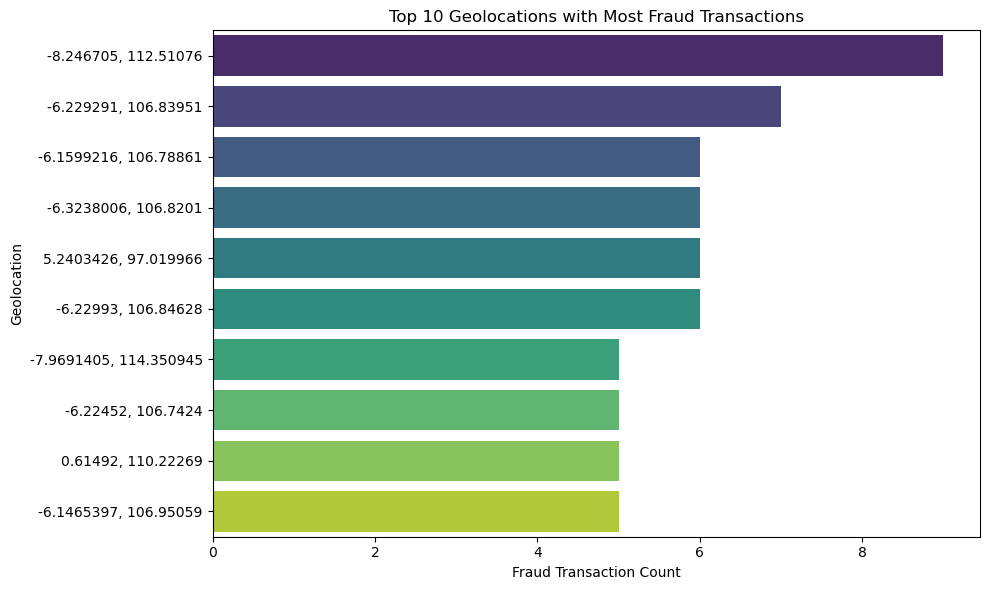

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for fraud transactions
fraud_transactions = main_feature_df.filter(P.col("is_fraud") == True)

# Grouping by geolocation to count transactions
geolocation_fraud_count = fraud_transactions.groupBy("geolocation").agg(
    P.count("transaction_id").alias("fraud_transaction_count")
)

# Sorting by transaction to count in descending order
geolocation_fraud_count = geolocation_fraud_count.orderBy(P.desc("fraud_transaction_count"))

# Converting to Pandas DataFrame for plotting
geolocation_fraud_count_pandas = geolocation_fraud_count.limit(10).toPandas()

# Plot a bar chart 
plt.figure(figsize=(10, 6))
sns.barplot(x='fraud_transaction_count', y='geolocation', data=geolocation_fraud_count_pandas, palette='viridis')
plt.title('Top 10 Geolocations with Most Fraud Transactions')
plt.xlabel('Fraud Transaction Count')
plt.ylabel('Geolocation')
plt.tight_layout()


plt.show()


The above graph shows the top ten geolocations with the most fraudulent transactions. Understanding these geolocations is crucial for the following reasons:

* Fraud Detection Focus: By identifying places with higher fraud rates, businesses can commit more resources and establish tailored techniques to detect suspicious activity. For example, focusing fraud detection algorithms on transactions originating from the top geolocation (-8.246705, 112.51076), which has the greatest fraud rate, can effectively reduce risks.
* Geolocation-Based Risk Profiling: Businesses can carry out geolocation-based risk assessments. Transactions from high-risk areas can be marked for further verification, helping businesses to prevent fraud before it affects their financial operations.
* Preventive Measures: By identifying hotspots for fraudulent behavior, businesses can alert local authorities and strengthen security processes. Preventive interventions such as enhanced verification, multi-factor authentication, and transaction limitations in high-risk regions are all options.

## Part 2. Feature extraction and ML training <a class="anchor" name="part-2"></a>
In this section, you must use PySpark DataFrame functions and ML packages for data preparation, model building, and evaluation. Other ML packages, such as scikit-learn, would receive zero marks.
### 2.1 Discuss the feature selection and prepare the feature columns

2.1.1 Based on the data exploration from 1.2 and considering the use case, discuss the importance of those features (For example, which features may be useless and should be removed, which feature has a significant impact on the label column, which should be transformed), which features you are planning to use? Discuss the reasons for selecting them and how you create/transform them
300 words max for the discussion
Please only use the provided data for model building
You can create/add additional features based on the dataset
Hint - Use the insights from the data exploration/domain knowledge/statistical models to consider whether to create more feature columns, whether to remove some columns

* After Performing chi-square test on categorical columns and correlations analysis on the numeric column to consider the is_fraud as target or the lable int below cells of 2.2.2 here are the conclusions 
#### Columns Considered for the feature selections
* Total Amount: Higher transaction figures may indicate fraudulent activity, especially if odd spikes are seen. Its link with L1_count (0.49) implies that fraudsters may target bulk or high-value purchases, which is critical for detecting suspicious transactions.
* L1_count, L2_count, and L3_count: These features refers to purchasing and brosing behaviors of the customers and are critical for determining the nature of the fraudsters purchase behaviours. 
* Purchase Count: This feature helps identify repeated tiny purchases, which is a common method used by fraudsters to evade discovery by performing multiple smaller transactions. Its association with total_amount (0.47) validates its inclusion by balancing the scale. It balances the scale of transaction frequency and value.
* Payment Status and Clear Payment: Both features are same one being string and other being int and are directly related to payment outcomes. They aid in the detection of unsuccessful or suspicious payment attempts, which are frequently linked to fraudulent conduct, making them crucial in forecasting is_fraud either one of them can be considered. 
* Device Type: A p-value of 0.01 shows that device type can provide insight into fraudsters' activities, such as employing anonymous or unfamiliar devices, hence adding another layer of fraud detection. 
* item_price which inside the transaction file will also be considered since it will help us to detetct fradulent behaviors. 
#### Columns dropped 
* Promo Code: With a p-value of 0.60, there is no significant link with fraud detection. Fraudulent activity is rarely associated with promo codes, therefore deleting this parameter simplifies the model without sacrificing predictive value.
* Gender: A p-value of 0.79 indicates no significant link with fraud behavior, hence it can be eliminated because including it may introduce noise while not enhancing model accuracy. 
* Same follows with the shipement fee item quantity hour_of_day all these coulmn do not have siginificant correlations with the label column and their exclusion will reduce noise while building model for predicitions.  

2.1.2 Write code to create/transform the columns based on your discussion above
Hint: You can use one data frame for both use cases (classification and k-mean later in part 3) since you can select your desired columns as the input and output for each use case. 

In [15]:
# Converting the boolean 'is_fraud' column to integer
main_feature_df = main_feature_df.withColumn("is_fraud_int", P.col("is_fraud").cast("int"))

# Checking the conversion
main_feature_df.select("is_fraud", "is_fraud_int").show(5)


+--------+------------+
|is_fraud|is_fraud_int|
+--------+------------+
|   false|           0|
|   false|           0|
|   false|           0|
|   false|           0|
|   false|           0|
+--------+------------+
only showing top 5 rows



In [16]:
# Column names and their data types in a formatted way
for col_name, col_type in main_feature_df.dtypes:
    print(f"Column: {col_name}, Type: {col_type}")

Column: transaction_id, Type: string
Column: customer_id, Type: string
Column: session_id, Type: string
Column: created_at, Type: timestamp
Column: product_metadata, Type: string
Column: payment_method, Type: string
Column: payment_status, Type: string
Column: promo_amount, Type: float
Column: promo_code, Type: string
Column: shipment_fee, Type: float
Column: shipment_location_lat, Type: float
Column: shipment_location_long, Type: float
Column: total_amount, Type: float
Column: clear_payment, Type: string
Column: L1_count, Type: bigint
Column: L2_count, Type: bigint
Column: L3_count, Type: bigint
Column: L1_ratio, Type: double
Column: L2_ratio, Type: double
Column: hour_of_day, Type: int
Column: time_of_day, Type: string
Column: gender, Type: string
Column: age, Type: bigint
Column: first_join_year, Type: int
Column: geolocation, Type: string
Column: purchase_count, Type: bigint
Column: is_fraud, Type: boolean
Column: is_fraud_int, Type: int


In [17]:
import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType, StructType, StructField, IntegerType, FloatType

# Defining the schema for the product metadata
product_metadata_schema = ArrayType(
    StructType([
        StructField("product_id", IntegerType(), True),
        StructField("quantity", IntegerType(), True),
        StructField("item_price", FloatType(), True)
    ])
)

# Parsing the product_metadata column into array of structs
main_feature_df = main_feature_df.withColumn(
    "product_metadata_extracted",
    F.from_json(F.col("product_metadata"), product_metadata_schema)
)

# Seperating the array of structs into separate rows for each product in the product_metadata
main_feature_df = main_feature_df.withColumn("exploded_product_metadata", F.explode("product_metadata_extracted"))

# Extracting individual fields from the seperated fields 
main_feature_df = main_feature_df.withColumn("product_id", F.col("exploded_product_metadata.product_id"))
main_feature_df = main_feature_df.withColumn("quantity", F.col("exploded_product_metadata.quantity"))
main_feature_df = main_feature_df.withColumn("item_price", F.col("exploded_product_metadata.item_price"))

# Verifying the extracted columns 
main_feature_df.select("transaction_id", "product_id", "quantity", "item_price").show(10, truncate=False)

+------------------------------------+----------+--------+----------+
|transaction_id                      |product_id|quantity|item_price|
+------------------------------------+----------+--------+----------+
|511f59f8-3ef5-4388-b654-1a8c3da62819|40686     |1       |266512.0  |
|8e509f58-7f8d-421d-b7bf-8f41db0ed911|24039     |1       |182915.0  |
|8e509f58-7f8d-421d-b7bf-8f41db0ed911|57425     |1       |130574.0  |
|29d32f23-a07a-4f20-a3c4-77801ad2516c|21145     |1       |255028.0  |
|a3e90650-4db3-408d-be16-79b432af0f86|27913     |7       |120541.0  |
|12ffdc68-a0ba-44e6-92e5-51173a6c91b1|56646     |1       |271002.0  |
|430dc90b-6c04-408c-9b4e-09147c9c2367|1869      |1       |305512.0  |
|89a39293-dee2-48a4-b1b5-f9eda8ca688d|22555     |1       |181627.0  |
|cddea303-22d6-41f7-ae79-149bb915d017|29890     |1       |293088.0  |
|cddea303-22d6-41f7-ae79-149bb915d017|18472     |1       |153769.0  |
+------------------------------------+----------+--------+----------+
only showing top 10 

In [18]:
# Joining product to get 'category_id'
main_feature_df = main_feature_df.join(df_product.select(F.col("id").alias("product_id"), "category_id"),
                                       on="product_id", how="left")

# Join category to get 'cat_level1', 'cat_level2', 'cat_level3'
main_feature_df = main_feature_df.join(df_category.select("category_id", "cat_level1", "cat_level2", "cat_level3"), on="category_id", how="left")

# Verifying the updated Dataframe 
main_feature_df.select("product_id", "category_id", "cat_level1", "cat_level2", "cat_level3").show(5)


+----------+-----------+----------+----------+------------+
|product_id|category_id|cat_level1|cat_level2|  cat_level3|
+----------+-----------+----------+----------+------------+
|     40686|          3|  Footwear|     Shoes|Casual Shoes|
|     24039|         40|   Apparel|   Topwear|     Tshirts|
|     57425|         40|   Apparel|   Topwear|     Tshirts|
|     21145|         67|   Apparel|   Topwear|      Shirts|
|     27913|         86|   Apparel|Bottomwear|    Trousers|
+----------+-----------+----------+----------+------------+
only showing top 5 rows



In [19]:
# Adding traffic_source and device_type from df_browsing_behaviour to main_feature_df using session_id
main_feature_df = main_feature_df.join(
    df_browsing_behaviour.select("session_id", "traffic_source", "device_type"),
    on="session_id",
    how="left"
)

# Verifying the addition of new columns
main_feature_df.select("session_id", "traffic_source", "device_type").show(10)


+--------------------+--------------+-----------+
|          session_id|traffic_source|device_type|
+--------------------+--------------+-----------+
|39c4223a-2cfb-4ec...|           WEB|    Android|
|39c4223a-2cfb-4ec...|           WEB|    Android|
|39c4223a-2cfb-4ec...|           WEB|    Android|
|39c4223a-2cfb-4ec...|           WEB|    Android|
|39c4223a-2cfb-4ec...|           WEB|    Android|
|39c4223a-2cfb-4ec...|           WEB|    Android|
|39c4223a-2cfb-4ec...|           WEB|    Android|
|39c4223a-2cfb-4ec...|           WEB|    Android|
|39c4223a-2cfb-4ec...|           WEB|    Android|
|39c4223a-2cfb-4ec...|           WEB|    Android|
+--------------------+--------------+-----------+
only showing top 10 rows



In [20]:
# Creating a copy of the main_feature_df for backup purposes 
main_feature_df_copy = main_feature_df

# Droping duplicates based on 'transaction_id' in the copied DataFrame resulted in the above transformations
unique_main_feature_df = main_feature_df_copy.dropDuplicates(['transaction_id'])

# Verifying that duplicates whether the duplicated are dropped by comparing the counts
print(f"Original count: {main_feature_df.count()}")
print(f"Unique transactions count (after dropping duplicates): {unique_main_feature_df.count()}")


Original count: 16927739
Unique transactions count (after dropping duplicates): 657989


In [21]:
import pandas as pd
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.stat import ChiSquareTest

main_feature_df_copy = main_feature_df.dropDuplicates(['transaction_id'])

# Using StringIndexer to convert categorical variables into numeric indices
indexer = StringIndexer(
    inputCols=["payment_method", "payment_status", "promo_code", 
               "clear_payment", "time_of_day", "gender", "cat_level1", 
               "cat_level2", "cat_level3", "traffic_source", "device_type"],
    outputCols=["payment_method_idx", "payment_status_idx", "promo_code_idx", 
                "clear_payment_idx", "time_of_day_idx", "gender_idx", "cat_level1_idx", 
                "cat_level2_idx", "cat_level3_idx", "traffic_source_idx", "device_type_idx"],
    handleInvalid="skip" 
)

# Applying the indexer on the deduplicated DataFrame
indexed_df = indexer.fit(main_feature_df_copy).transform(main_feature_df_copy)

# Assembling categorical columns into a feature vector for Chi-Square Test
assembler = VectorAssembler(
    inputCols=["payment_method_idx", "payment_status_idx", "promo_code_idx", 
               "clear_payment_idx", "time_of_day_idx", "gender_idx", "cat_level1_idx", 
               "cat_level2_idx", "cat_level3_idx", "traffic_source_idx", "device_type_idx"],
    outputCol="features"
)

# Applying assembler to create the feature vector
assembled_df = assembler.transform(indexed_df)

# Implementing Chi-Square Test for categorical features against 'is_fraud_int'
chi_square_test_result = ChiSquareTest.test(assembled_df, "features", "is_fraud_int")

# Collecting the results and convert them into a Pandas DataFrame
chi_square_results = chi_square_test_result.select("pValues", "degreesOfFreedom", "statistics").collect()

# Extracting and formatting values
p_values = chi_square_results[0]["pValues"]
degrees_of_freedom = chi_square_results[0]["degreesOfFreedom"]
statistics = chi_square_results[0]["statistics"]

# Pandas Data frame to format the results
chi_square_df = pd.DataFrame({
    "Feature": ["payment_method", "payment_status", "promo_code", 
                "clear_payment", "time_of_day", "gender", "cat_level1", 
                "cat_level2", "cat_level3", "traffic_source", "device_type"],
    "p-value": p_values,
    "Degrees of Freedom": degrees_of_freedom,
    "Chi-Square Statistic": statistics
})

# Formatted results
print(chi_square_df)


           Feature   p-value  Degrees of Freedom  Chi-Square Statistic
0   payment_method  0.136565                   4              6.987224
1   payment_status  0.000000                   1            665.637918
2       promo_code  0.608768                   7              5.420680
3    clear_payment  0.000000                   1            665.637918
4      time_of_day  0.171559                   3              5.003260
5           gender  0.793518                   1              0.068510
6       cat_level1  0.776283                   6              3.254576
7       cat_level2  0.470297                  44             44.031751
8       cat_level3  0.968619                 142            112.323658
9   traffic_source  0.398010                   1              0.714329
10     device_type  0.013682                   1              6.078709


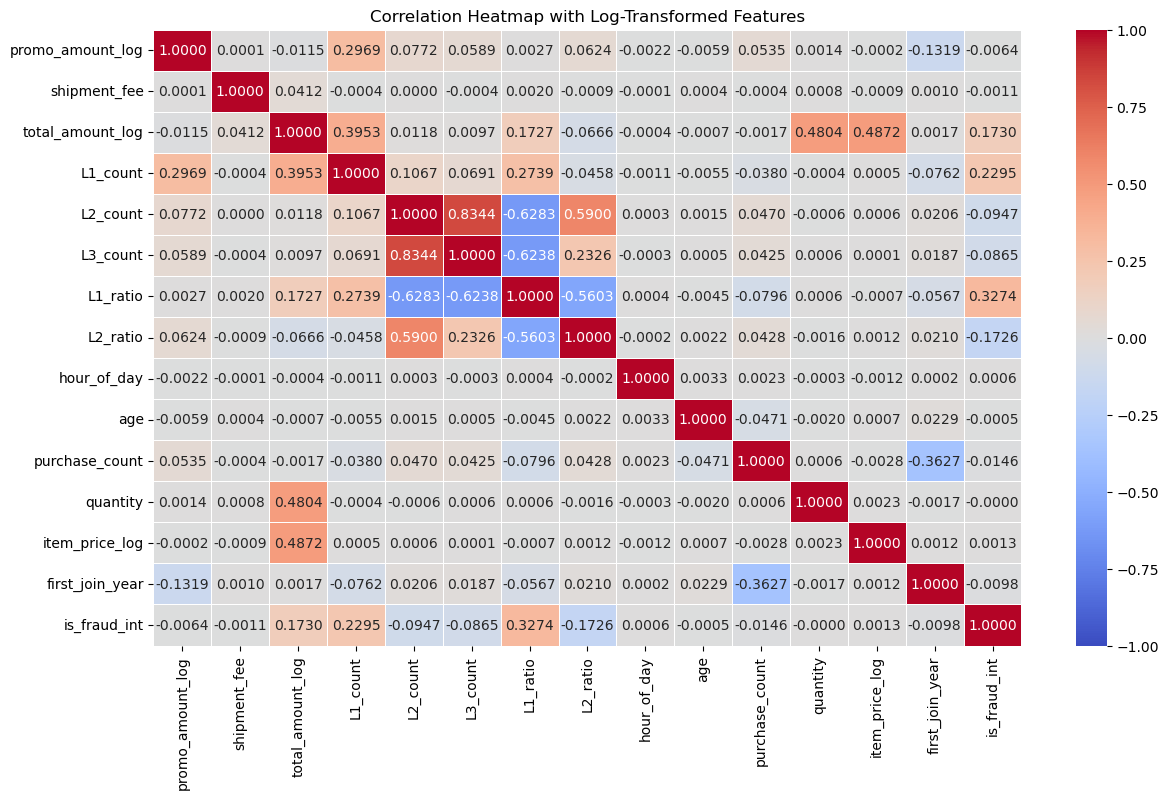

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import functions as F

# Performing log scale for columns with high numeric values 
main_feature_df_copy = main_feature_df_copy.withColumn("promo_amount_log", F.log1p("promo_amount"))
main_feature_df_copy = main_feature_df_copy.withColumn("total_amount_log", F.log1p("total_amount"))
main_feature_df_copy = main_feature_df_copy.withColumn("item_price_log", F.log1p("item_price"))

# Considering relevant numeric columns
numeric_columns = [
    "promo_amount_log", "shipment_fee", "total_amount_log", "L1_count", "L2_count", 
    "L3_count", "L1_ratio", "L2_ratio", "hour_of_day", "age", "purchase_count", 
    "quantity", "item_price_log", "first_join_year", "is_fraud_int"
]

# Spark data frame to pandas dataframe for plotting 
numeric_data = main_feature_df_copy.select(numeric_columns).toPandas()

# Generating the correlation matrix
correlation_matrix = numeric_data.corr().round(4)

# Plotting the correlation heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".4f", linewidths=0.5)
plt.title("Correlation Heatmap with Log-Transformed Features")
plt.savefig('output_plot.png')  # Save the heatmap as a PNG image
plt.show()

### 2.2 Preparing Spark ML Transformers/Estimators for features, labels, and models  <a class="anchor" name="2.2"></a>

**2.2.1 Write code to create Transformers/Estimators for transforming/assembling the columns you selected above in 2.1 and create ML model Estimators for Random Forest (RF) and Gradient-boosted tree (GBT) model.
Please DO NOT fit/transform the data yet.**

In [23]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml import Pipeline

# Considered Categorical columns
categorical_cols = ['payment_method', 'payment_status', 'device_type']

# Considered Numeric columns 
numeric_cols = ['total_amount_log', 'L1_count', 'L2_count', 'L3_count', 'L1_ratio', 'purchase_count']

# StringIndexers for the categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_cols]

# Assembling all features into a single vector column
assembler = VectorAssembler(inputCols=[col + "_index" for col in categorical_cols] + numeric_cols, 
                            outputCol="features_assembled")

# Standardize scale for numeric features 
scaler = StandardScaler(inputCol="features_assembled", outputCol="features", withStd=True, withMean=False)

# Defining the Random Forest Estimators
rf = RandomForestClassifier(labelCol="is_fraud_int", featuresCol="features")

# Defining the Gradient-Boosted Tree Estimator
gbt = GBTClassifier(labelCol="is_fraud_int", featuresCol="features")

# Creating the pipeline for Random Forest
pipeline_rf = Pipeline(stages=indexers + [assembler, scaler, rf])

# Creating the pipeline for Gradient-Boosted Trees
pipeline_gbt = Pipeline(stages=indexers + [assembler, scaler, gbt])

# Output of the pipeline structure 
print("Pipelines are ready:")
print("Random Forest Pipeline Stages: ", pipeline_rf.getStages())
print("Gradient-Boosted Trees Pipeline Stages: ", pipeline_gbt.getStages())


Pipelines are ready:
Random Forest Pipeline Stages:  [StringIndexer_f5a1b18d541b, StringIndexer_6fc671d697e2, StringIndexer_1ccf39701ec2, VectorAssembler_e8ef4c3db2d7, StandardScaler_57ac828e8f08, RandomForestClassifier_802b471ad43a]
Gradient-Boosted Trees Pipeline Stages:  [StringIndexer_f5a1b18d541b, StringIndexer_6fc671d697e2, StringIndexer_1ccf39701ec2, VectorAssembler_e8ef4c3db2d7, StandardScaler_57ac828e8f08, GBTClassifier_5431a1550613]


**2.2.2. Write code to include the above Transformers/Estimators into two pipelines.
Please DO NOT fit/transform the data yet.**

In [24]:

# Random Forest Pipeline 
pipeline_rf = Pipeline(stages=indexers + [assembler, scaler, rf])

# Gradient-Boosted Trees Pipeline
pipeline_gbt = Pipeline(stages=indexers + [assembler, scaler, gbt])

# Output of the pipeline structure 
print("Pipelines are ready:")
print("Random Forest Pipeline Stages: ", pipeline_rf.getStages())
print("Gradient-Boosted Trees Pipeline Stages: ", pipeline_gbt.getStages())


Pipelines are ready:
Random Forest Pipeline Stages:  [StringIndexer_f5a1b18d541b, StringIndexer_6fc671d697e2, StringIndexer_1ccf39701ec2, VectorAssembler_e8ef4c3db2d7, StandardScaler_57ac828e8f08, RandomForestClassifier_802b471ad43a]
Gradient-Boosted Trees Pipeline Stages:  [StringIndexer_f5a1b18d541b, StringIndexer_6fc671d697e2, StringIndexer_1ccf39701ec2, VectorAssembler_e8ef4c3db2d7, StandardScaler_57ac828e8f08, GBTClassifier_5431a1550613]


### 2.3 Preparing the training data and testing data  
Write code to split the data for training and testing purposes.
Note: Due to the large dataset size, you can use random sampling (say 20% of the dataset) and do a train/test split or use one year of data for training and another year for testing. 

In [25]:
# Sampling 20% of the main feature data set 
sampled_df = unique_main_feature_df.sample(withReplacement=False, fraction=0.20, seed=42)

# Splitting the sampled data into 80% training and 20% testing sets
train_df, test_df = sampled_df.randomSplit([0.8, 0.2], seed=42)

# Displaying the counts for verification
print(f"Total records in sampled data: {sampled_df.count()}")
print(f"Training Dataset Count: {train_df.count()}")
print(f"Testing Dataset Count: {test_df.count()}")


Total records in sampled data: 131965
Training Dataset Count: 105854
Testing Dataset Count: 26287


### 2.4 Training and evaluating models  
2.4.1 Write code to use the corresponding ML Pipelines to train the models on the training data from 2.3. And then use the trained models to predict the testing data from 2.3

In [26]:
from pyspark.sql.functions import log1p

# Applying log transformation to 'total_amount'
train_df = train_df.withColumn("total_amount_log", log1p(train_df["total_amount"]))
test_df = test_df.withColumn("total_amount_log", log1p(test_df["total_amount"]))

In [27]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.storagelevel import StorageLevel
import concurrent.futures

# Caching the training and test dataframes to avoid recomputation
train_df.persist(StorageLevel.MEMORY_AND_DISK)
test_df.persist(StorageLevel.MEMORY_AND_DISK)

# redcuing the depth of the tree 
rf = RandomForestClassifier(labelCol="is_fraud_int", featuresCol="features", numTrees=50)
gbt = GBTClassifier(labelCol="is_fraud_int", featuresCol="features", maxIter=10)

# Updating the pipelines
pipeline_rf = Pipeline(stages=indexers + [assembler, scaler, rf])
pipeline_gbt = Pipeline(stages=indexers + [assembler, scaler, gbt])

# Training models in parallel for faster computations
def fit_rf():
    return pipeline_rf.fit(train_df)

def fit_gbt():
    return pipeline_gbt.fit(train_df)

with concurrent.futures.ThreadPoolExecutor() as executor:
    rf_future = executor.submit(fit_rf)
    gbt_future = executor.submit(fit_gbt)

    rf_model = rf_future.result()
    gbt_model = gbt_future.result()

# Predictions
rf_predictions = rf_model.transform(test_df)
gbt_predictions = gbt_model.transform(test_df)

# Evaluating the models using metrics
evaluator = BinaryClassificationEvaluator(labelCol="is_fraud_int", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Random Forest Evaluation
rf_auc = evaluator.evaluate(rf_predictions)
print(f"Random Forest AUC: {rf_auc}")

# Gradient-Boosted Tree Evaluation
gbt_auc = evaluator.evaluate(gbt_predictions)
print(f"Gradient-Boosted Trees AUC: {gbt_auc}")

# Confusion matrix for Random Forest
rf_predictions.groupBy("is_fraud_int", "prediction").count().show()

# Confusion matrix for Gradient-Boosted Trees
gbt_predictions.groupBy("is_fraud_int", "prediction").count().show()

# Calculating the accuracy for Random Forest
correct_rf = rf_predictions.filter(rf_predictions.is_fraud_int == rf_predictions.prediction).count()
total_rf = rf_predictions.count()
rf_accuracy = correct_rf / total_rf
print(f"Random Forest Accuracy: {rf_accuracy}")

# Calculating accuracy for Gradient-Boosted Trees
correct_gbt = gbt_predictions.filter(gbt_predictions.is_fraud_int == gbt_predictions.prediction).count()
total_gbt = gbt_predictions.count()
gbt_accuracy = correct_gbt / total_gbt
print(f"Gradient-Boosted Trees Accuracy: {gbt_accuracy}")

# Freeing up memory space after completion of all the operations. 
train_df.unpersist()
test_df.unpersist()


Random Forest AUC: 0.9999381099821508
Gradient-Boosted Trees AUC: 0.999999518535929
+------------+----------+-----+
|is_fraud_int|prediction|count|
+------------+----------+-----+
|           1|       1.0|  442|
|           0|       0.0|25819|
|           0|       1.0|   26|
+------------+----------+-----+

+------------+----------+-----+
|is_fraud_int|prediction|count|
+------------+----------+-----+
|           1|       1.0|  441|
|           0|       0.0|25844|
|           0|       1.0|    1|
|           1|       0.0|    1|
+------------+----------+-----+

Random Forest Accuracy: 0.999010917944231
Gradient-Boosted Trees Accuracy: 0.9999239167649409


DataFrame[session_id: string, category_id: string, product_id: int, transaction_id: string, customer_id: string, created_at: timestamp, product_metadata: string, payment_method: string, payment_status: string, promo_amount: float, promo_code: string, shipment_fee: float, shipment_location_lat: float, shipment_location_long: float, total_amount: float, clear_payment: string, L1_count: bigint, L2_count: bigint, L3_count: bigint, L1_ratio: double, L2_ratio: double, hour_of_day: int, time_of_day: string, gender: string, age: bigint, first_join_year: int, geolocation: string, purchase_count: bigint, is_fraud: boolean, is_fraud_int: int, product_metadata_extracted: array<struct<product_id:int,quantity:int,item_price:float>>, exploded_product_metadata: struct<product_id:int,quantity:int,item_price:float>, quantity: int, item_price: float, cat_level1: string, cat_level2: string, cat_level3: string, traffic_source: string, device_type: string, total_amount_log: double]

2.4.2 For both models (RF and GBT) and testing data, write code to display the count of TP/TN/FP/FN. Compute the AUC, accuracy, recall, and precision for the above-threshold/below-threshold label from each model testing result using PySpark MLlib/ML APIs.
Draw a ROC plot.
Discuss which one is the better model (no word limit; please keep it concise)

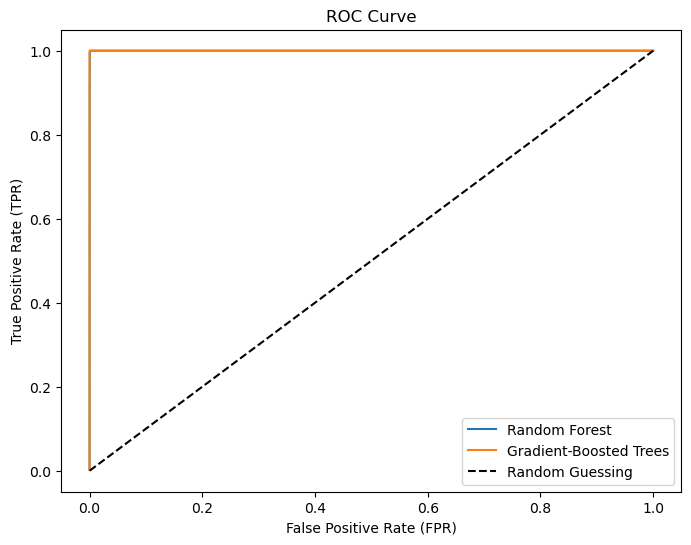

Random Forest Metrics:
TP: 442, TN: 25819, FP: 26, FN: 0
Accuracy: 0.999010917944231, Precision: 0.9444444444444444, Recall: 1.0, AUC: 0.9999381099821507
Gradient-Boosted Trees Metrics:
TP: 441, TN: 25844, FP: 1, FN: 1
Accuracy: 0.9999239167649409, Precision: 0.997737556561086, Recall: 0.997737556561086, AUC: 0.999999518535929


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.functions import vector_to_array

# To compute ROC curve 
def compute_roc(predictions, label_col, probability_col):
    # Converting the 'probability' vector to an array and retrieving the probability for class 1 (is_fraud = 1)
    predictions = predictions.withColumn("probability", vector_to_array(probability_col)[1])
    
    # Sort by descending probability
    pred_pd = predictions.select("probability", label_col).orderBy("probability", ascending=False).toPandas()
    
    # Initialize values
    tps, fps = 0, 0
    tp_total = pred_pd[label_col].sum()  # Total number of positives (True Positive count)
    fp_total = pred_pd.shape[0] - tp_total  # Total number of negatives (False Positive count)

    # Lists to store FPR and TPR
    tpr_list, fpr_list = [], []

    for i in range(len(pred_pd)):
        if pred_pd[label_col].iloc[i] == 1:
            tps += 1  # True positive
        else:
            fps += 1  # False positive
        
        tpr = tps / tp_total if tp_total != 0 else 0  # TPR = TP / (TP + FN)
        fpr = fps / fp_total if fp_total != 0 else 0  # FPR = FP / (FP + TN)
        
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    
    return np.array(fpr_list), np.array(tpr_list)

# Function to compute accuracy, precision, and recall
def compute_metrics(predictions, label_col="is_fraud_int"):
    # Cache predictions to avoid recomputation
    predictions.cache()

    # groupby for faster executions 
    metrics_df = predictions.groupBy("prediction", label_col).count().toPandas()
    
    # Initializing TP, TN, FP, FN
    TP = metrics_df[(metrics_df['prediction'] == 1) & (metrics_df[label_col] == 1)]['count'].sum()
    TN = metrics_df[(metrics_df['prediction'] == 0) & (metrics_df[label_col] == 0)]['count'].sum()
    FP = metrics_df[(metrics_df['prediction'] == 1) & (metrics_df[label_col] == 0)]['count'].sum()
    FN = metrics_df[(metrics_df['prediction'] == 0) & (metrics_df[label_col] == 1)]['count'].sum()
    
    # Computeing Accuracy, Precision, Recall
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0

    # Unpersist the cached DataFrame after computation
    predictions.unpersist()

    return TP, TN, FP, FN, accuracy, precision, recall

# Computing ROC data for Random Forest
fpr_rf, tpr_rf = compute_roc(rf_predictions, "is_fraud_int", rf_predictions["probability"])

# Computing Compute ROC data for Gradient-Boosted Trees
fpr_gbt, tpr_gbt = compute_roc(gbt_predictions, "is_fraud_int", gbt_predictions["probability"])

# Plotting the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.plot(fpr_gbt, tpr_gbt, label="Gradient-Boosted Trees")
plt.plot([0, 1], [0, 1], "k--", label="Random Guessing")

# Labels and Title
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# displaying evaluation metrics
evaluator = BinaryClassificationEvaluator(labelCol="is_fraud_int", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Evaluating Random Forest metrics
rf_auc = evaluator.evaluate(rf_predictions)
tp_rf, tn_rf, fp_rf, fn_rf, accuracy_rf, precision_rf, recall_rf = compute_metrics(rf_predictions)
print(f"Random Forest Metrics:\nTP: {tp_rf}, TN: {tn_rf}, FP: {fp_rf}, FN: {fn_rf}")
print(f"Accuracy: {accuracy_rf}, Precision: {precision_rf}, Recall: {recall_rf}, AUC: {rf_auc}")

# Evaluating Gradient-Boosted Trees metrics
gbt_auc = evaluator.evaluate(gbt_predictions)
tp_gbt, tn_gbt, fp_gbt, fn_gbt, accuracy_gbt, precision_gbt, recall_gbt = compute_metrics(gbt_predictions)
print(f"Gradient-Boosted Trees Metrics:\nTP: {tp_gbt}, TN: {tn_gbt}, FP: {fp_gbt}, FN: {fn_gbt}")
print(f"Accuracy: {accuracy_gbt}, Precision: {precision_gbt}, Recall: {recall_gbt}, AUC: {gbt_auc}")


2.4.3 Save the better model (you need it for Part B of Assignment 2).
(Note: You may need to go through a few training loops or use more data to create a better-performing model.)

In [ ]:
best_model = gbt_model

### Part 3. Customer Clustering and Knowledge sharing with K-Mean <a class="anchor" name="part-3"></a>  
Please see the specification for this task and add code/markdown cells.

In [30]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.sql.functions import col

# Select relevant columns
numeric_cols = ['L1_count', 'L2_count', 'L3_count', 'total_amount', 'purchase_count', 'quantity', 'item_price']
categorical_cols = ['payment_status', 'traffic_source', 'device_type', 'cat_level1', 'cat_level2', 'cat_level3']

# Dropping null values from both numeric and categorical columns
unique_main_feature_df_cleaned = unique_main_feature_df.dropna(subset=numeric_cols + categorical_cols)

# Creating StringIndexers for categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_cols]

# Assembling all features into a single vector column
assembler = VectorAssembler(inputCols=[col + "_index" for col in categorical_cols] + numeric_cols, 
                            outputCol="features_assembled")

# Standardizing numeric features
scaler = StandardScaler(inputCol="features_assembled", outputCol="scaled_features", withStd=True, withMean=False)

# Extra
print("Transformers are ready:")
print(f"Indexers: {indexers}")
print(f"VectorAssembler: {assembler}")
print(f"StandardScaler: {scaler}")

# Applying transformations
indexer_pipeline = Pipeline(stages=indexers + [assembler, scaler])

# Fit the pipeline to the cleaned data
indexer_model = indexer_pipeline.fit(unique_main_feature_df_cleaned)
transformed_df = indexer_model.transform(unique_main_feature_df_cleaned)

# Display the schema and sample rows of the transformed DataFrame
transformed_df.printSchema()
transformed_df.select("scaled_features").show(5)


Transformers are ready:
Indexers: [StringIndexer_e74cbc0a6544, StringIndexer_959a98f520a2, StringIndexer_f71dcd852936, StringIndexer_b210adc46d66, StringIndexer_d41d77807ef3, StringIndexer_cced766c11bf]
VectorAssembler: VectorAssembler_6dbfe5cb3c42
StandardScaler: StandardScaler_5547ca1b43ed
root
 |-- session_id: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- transaction_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- product_metadata: string (nullable = true)
 |-- payment_method: string (nullable = true)
 |-- payment_status: string (nullable = true)
 |-- promo_amount: float (nullable = true)
 |-- promo_code: string (nullable = true)
 |-- shipment_fee: float (nullable = true)
 |-- shipment_location_lat: float (nullable = true)
 |-- shipment_location_long: float (nullable = true)
 |-- total_amount: float (nullable = true)
 |-- clear_payment: stri

In [33]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql import functions as F


# Selectting features based on the schema
categorical_cols = ['payment_method', 'payment_status', 'traffic_source', 'device_type', 'cat_level1', 'cat_level2', 'cat_level3']
numeric_cols = ['total_amount', 'L1_count', 'L1_ratio', 'purchase_count', 'quantity', 'item_price']

# Handling NULL values
df_final_cleaned = unique_main_feature_df.fillna({
    'total_amount': 0.0, 
    'L1_count': 0, 
    'L1_ratio': 0.0, 
    'purchase_count': 0, 
    'quantity': 0, 
    'item_price': 0.0,
    'payment_method': 'unknown', 
    'payment_status': 'unknown', 
    'traffic_source': 'unknown', 
    'device_type': 'unknown', 
    'cat_level1': 'unknown', 
    'cat_level2': 'unknown', 
    'cat_level3': 'unknown'
})

# Indexing categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index").fit(df_final_cleaned) for col in categorical_cols]

# Assembling the features into a single vector column
assembler = VectorAssembler(inputCols=[col + "_index" for col in categorical_cols] + numeric_cols, 
                            outputCol="features_assembled")

# Step 5: Standardize the numeric features
scaler = StandardScaler(inputCol="features_assembled", outputCol="scaled_features", withStd=True, withMean=False)


K: 2, Silhouette Score: 0.7185710730048342
K: 3, Silhouette Score: 0.5679459280091679
K: 4, Silhouette Score: 0.29742124218393895
K: 5, Silhouette Score: 0.3902670196137268
K: 6, Silhouette Score: 0.2953818024725539
K: 7, Silhouette Score: 0.3701346204501178
K: 8, Silhouette Score: 0.37495096375660225
K: 9, Silhouette Score: 0.38491809204169064
K: 10, Silhouette Score: 0.2837851304300941


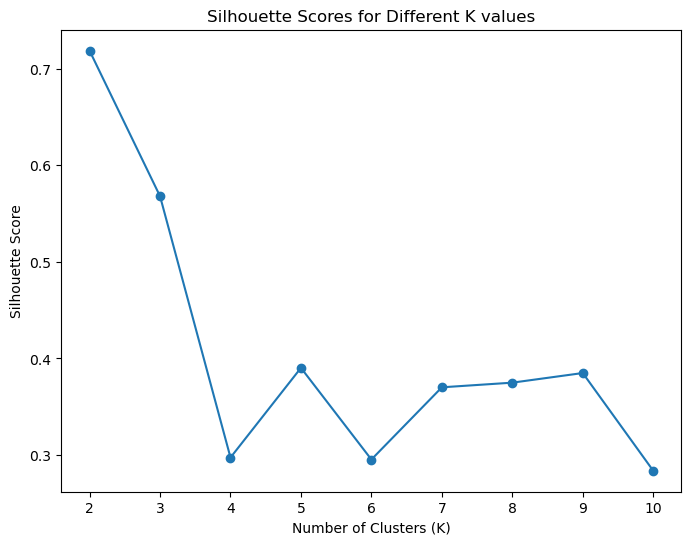

Optimal K based on Silhouette Score: 2
+-----------+------------+--------------+--------------------+----------+
|customer_id|total_amount|purchase_count| new_scaled_features|prediction|
+-----------+------------+--------------+--------------------+----------+
|      17423|    394028.0|            34|[1.70701759050042...|         0|
|      49334|    267012.0|            32|[1.70701759050042...|         0|
|      27813|    571276.0|             5|[0.85350879525021...|         0|
|      84911|    276451.0|            19|[0.85350879525021...|         0|
|      35635|    154044.0|            19|[1.28026319287531...|         0|
|      31815|    394899.0|             2|[2.13377198812553...|         0|
|      22515|    260008.0|             3|[0.85350879525021...|         0|
|       3119|    242537.0|            43|[4.69429837387617...|         0|
|      12786|    222326.0|            24|[0.85350879525021...|         0|
|      79361|    254925.0|            16|[1.70701759050042...|         0|

In [45]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

# Selecting the features from `transformed_df` for clustering
cluster_features = ['L1_count', 'L2_count', 'L3_count', 'total_amount', 'purchase_count', 'quantity', 'item_price']

# Assembling features into a single vector column
assembler = VectorAssembler(inputCols=cluster_features, outputCol="new_features_assembled")
transformed_df_assembled = assembler.transform(transformed_df)

# Feature Scaling 
scaler = StandardScaler(inputCol="new_features_assembled", outputCol="new_scaled_features", withStd=True, withMean=False)
scaled_df = scaler.fit(transformed_df_assembled).transform(transformed_df_assembled)

# ClusteringEvaluator for Silhouette Score 
evaluator = ClusteringEvaluator(featuresCol="new_scaled_features", metricName="silhouette", distanceMeasure="squaredEuclidean")

# K means Clustering range
K_values = list(range(2, 11))  # Testing K from 2 to 10
silhouette_scores = []

for k in K_values:
    kmeans = KMeans(featuresCol="new_scaled_features", k=k, seed=42)
    model = kmeans.fit(scaled_df)
    predictions = model.transform(scaled_df)
    
    # Compute the silhouette score
    silhouette = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette)
    print(f"K: {k}, Silhouette Score: {silhouette}")

# Plotting the Silhouette Scores
plt.figure(figsize=(8, 6))
plt.plot(K_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different K values')
plt.show()

# Selectting the best K
optimal_k = K_values[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal K based on Silhouette Score: {optimal_k}")

# Trainning the final K-Means model with the best K
best_kmeans = KMeans(featuresCol="new_scaled_features", k=optimal_k, seed=42)
best_kmeans_model = best_kmeans.fit(scaled_df)

# Predictions with the final model
df_best_clustered = best_kmeans_model.transform(scaled_df)

# Displayin the clustered data
df_best_clustered.select("customer_id", "total_amount", "purchase_count", "new_scaled_features", "prediction").show(10)

# Counting number of customers in each clusters.
df_best_clustered.groupBy("prediction").count().show()


#### * Fraudsters display various behaviors that distinguish them from legitimate clients and can be discovered using clustering methods such as K-means. 
#### * One prevalent characteristic is high-value transactions (from the total_amount column), in which fraudsters buy pricey products that are easy to resell. This activity is typically accompanied by several failed payment attempts (recorded in the payment_status column), since fraudsters routinely use stolen or unauthorized cards before making a transaction.

#### * Another crucial behavior is low browsing or search activity, as indicated by fewer entries in the total_actions column, implying that fraudsters rapidly skip to checkout without spending time studying the website. 
#### * Furthermore, fraudsters frequently execute multiple tiny transactions within a short period (recorded in the transactions_in_24hr column) a way for testing several stolen cards or circumventing fraud detection technologies. 

#### *These behaviors, derived from the relevant dataset columns, offer vital insights into fraudulent conduct, allowing for more effective fraud detection and prevention techniques.

### Part 4: Data Ethics, Privacy, and Security <a class="anchor" name="part-4"></a>  

## Data Ethics in Big Data Processing
#### Influence of Data Ethics on Big Data Processing 

* Informed Consent: Ethical data processing requires users to provide informed consent, indicating that they understand how their data will be gathered and used. In big data, this means that enterprises must properly convey their data practices to users.

* Privacy and Anonymity: Big data frequently involves the processing of personally identifiable information. Ethical methods ensure that this data is anonymised, protecting user privacy while providing important insights.
Ethical data use necessitates transparency in data collection, use, and sharing. Organizations must tell users about their data management policies in order to preserve confidence.

* Prejudice and Fairness: Big data systems may accidentally produce prejudice. Ethical approaches aim to reduce these biases and ensure fair decision-making and outcomes.

* Security and duty: Data security is a fundamental ethical duty. Companies must ensure the data. To secure personal information, businesses must maintain data security and follow requirements such as GDPR.

#### Real-world Example of Instagram browsing behavior:

* Positive handling: Instagram uses surfing data to tailor the user experience by suggesting posts, accounts, or adverts depending on individual preferences. This benefits consumers by delivering relevant material based on their preferences, making their experience more enjoyable and engaging.

* Negative handling: Instagram has been under fire for exploiting browser data to target vulnerable individuals, such as advertising dangerous content on mental health issues. This approach raises ethical considerations because it may exploit consumers' emotional emotions for profit. Furthermore, Instagram's usage of data for automated judgments might result in "filter bubbles," which limit exposure to varied perspectives, contribute to disinformation, and reinforce biases.

* For example, the 2021 whistleblower testimony on Facebook (Instagram's parent company) highlighted how its algorithms valued engagement over customer well-being.exposing people to hazardous content despite internal alerts suggesting the risk of harm.


#### Balance between technological advancements and ethical responsibilities 

* The rapid advancement of data technologies frequently outpaces the development of ethical standards. While AI and big data offer advances like predictive analytics and personalized services, they also raise the possibility of data misuse.

* Balancing technical advancement with ethical responsibility entails providing transparency in data processing procedures while limiting dangers such as algorithm bias and privacy infringement.

* Ethical responsibility entails creating fair systems that do not abuse user data for malicious ends. Organizations must emphasize user well-being and privacy as they continue to develop.

* For example, Instagram's continual algorithm upgrades attempt to improve user engagement, but ethical concerns arise when these updates reinforce detrimental habits, such as excessive screen time or the promotion of dangerous content. Balancing the desire for technological efficiency and ethical responsibility is critical for limiting the harmful effects on consumers.

## References:

* General Data Protection Regulation. (n.d.). Retrieved from https://gdpr.eu
* CBS News. (2021, October 3). Facebook whistleblower Frances Haugen: The 60 Minutes interview. CBS News. Retrieved from https://www.cbsnews.com/news/facebook-whistleblower-frances-haugen-misinformation-public-60-minutes-2021-10-03/
* Council of Europe. (n.d.). Common ethical challenges in AI. Retrieved from https://www.coe.int/en/web/bioethics/common-ethical-challenges-in-ai
* Telecom Review. (2023). The ethics of technology: Balancing innovation and responsibility. https://www.telecomreview.com/articles/reports-and-coverage/7348-the-ethics-of-technology-balancing-innovation-and-responsibility/
* Stack Overflow. (2014). How to set Apache Spark Executor memory? Retrieved from https://stackoverflow.com/questions/26562033/how-to-set-apache-spark-executor-memory?rq=4
* Sparkcodehub. (n.d.). Persist vs cache in Spark. Sparkcodehub. https://www.sparkcodehub.com/spark/persist-vs-cache-in-spark
* BinaryClassificationEvaluator for Model Metrics: Apache Spark. (n.d.). BinaryClassificationEvaluator. Apache Spark Documentation. https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.BinaryClassificationEvaluator.html
* Sparkcodehub. (n.d.). Mastering persistence and caching in PySpark. Sparkcodehub. https://www.sparkcodehub.com/pyspark/mastering-persistence-and-caching
* Sparkcodehub. (n.d.). PySpark DataFrame persistence: Enhance your data processing. Sparkcodehub.  https://www.sparkcodehub.com/pyspark-dataframe-persistence